<a href="https://colab.research.google.com/github/qkrwoghd04/Image-text_fusion_for_binary_classification_using_BERT-ViT/blob/master/practice/vit_classification_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch
!pip install torchinfo
!pip install ray
!pip install -U tensorboardx

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
import os
import sys
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
# Image Classification
import torch
from torchvision.transforms import v2
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import argparse
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from functools import partial
import os
import tempfile
from pathlib import Path
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
import ray.cloudpickle as pickle

In [4]:
# Training device:
device = 'cuda'

# hyperparameter
learning_rate = 1e-4
batch_size = 64
epochs = 20
# based on paper's "attention is all you need"
BATCH_SIZE = 64
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2 #(3 * 16 * 16) = 768
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2) #((224*224)/

In [5]:
class CustomImageDataset():
  def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_file = pd.read_csv(os.path.join(img_dir, csv_file))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

  def __len__(self):
    return len(self.img_file)

  def __getitem__(self, index):
    # 레이블을 기반으로 서브폴더 경로 결정
    label = self.img_file.iloc[index, 2]
    subfolder = 'Sleep' if label == 'Sleep' else 'Fall'
    img_path = os.path.join(self.img_dir, 'train', subfolder, self.img_file.iloc[index, 0])
    if(label == "Sleep"):
       label = 0
    else: label = 1
    image = read_image(img_path)
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return image, label

In [6]:
def image_transform():

  H, W = 224, 224
  img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

  transforms = v2.Compose([
      v2.RandomResizedCrop(size=(224, 224), antialias=True),
      v2.RandomPhotometricDistort(p=1),
      v2.RandomChannelPermutation() ,# 채널 무작위 변경
      v2.RandomHorizontalFlip(p=0.2),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])


  return transforms


def visualize_data(train_dataloader):
    # 이미지와 정답(label)을 표시합니다.
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]

    if img.dim() == 3 and img.size(0) == 3:
        img = img.permute(1, 2, 0)

    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")

In [7]:
# class PatchEmbeddingLayer(nn.Module):
#     def __init__(self, in_channels, patch_size, embedding_dim):
#         super().__init__()
#         self.patch_size = patch_size
#         self.embedding_dim = embedding_dim
#         self.in_channels = in_channels
#         self.conv_layer = nn.Conv2d(in_channels=in_channels,
#                                     out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
#         self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
#         self.class_token_embeddings = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)
#         self.position_embeddings = nn.Parameter(torch.randn(1, NUM_OF_PATCHES + 1, embedding_dim), requires_grad=True)

#     def forward(self, x):
#         batch_size = x.size(0)
#         class_token_embeddings = self.class_token_embeddings.repeat(batch_size, 1, 1)
#         x = self.conv_layer(x)
#         x = x.permute(0, 2, 3, 1)
#         x = self.flatten_layer(x)
#         x = torch.cat((class_token_embeddings, x), dim=1)
#         x = x + self.position_embeddings
#         return x
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

In [8]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dims = 768, num_heads = 12, attn_dropout=0.0):
        super().__init__()
        self.embedding_dims = embedding_dims
        self.num_head = num_heads
        self.attn_dropout = attn_dropout
        self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
        self.multiheadattention = nn.MultiheadAttention(num_heads = num_heads,
                                                        embed_dim = embedding_dims,
                                                        dropout = attn_dropout,
                                                        batch_first = True,
                                                        )
    def forward(self, x):
        x = self.layernorm(x)
        output,_ = self.multiheadattention(query=x, key=x, value=x, need_weights=False)
        return output

In [9]:
class MachineLearningPerceptronBlock(nn.Module):
    def __init__(self, embedding_dims, mlp_size, mlp_dropout):
        super().__init__()
        self.embedding_dims = embedding_dims
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout

        self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dims, out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = mlp_dropout),
            nn.Linear(in_features = mlp_size, out_features = embedding_dims),
            nn.Dropout(p = mlp_dropout)
        )
    def forward(self,x):
        return self.mlp(self.layernorm(x))

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dims = 768,
                 mlp_dropout=0.1,
                 attn_dropout = 0.0,
                 mlp_size = 3072,
                 num_heads = 12,
                 ):
        super().__init__()

        self.mas_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims, num_heads = num_heads, attn_dropout=attn_dropout,)

        self.mlp_block = MachineLearningPerceptronBlock(embedding_dims=embedding_dims, mlp_size=mlp_size, mlp_dropout=mlp_dropout,)
    def forward(self, x):
        x = self.mas_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [11]:
class vit_model(nn.Module):
    def __init__(self, img_size = 224, in_channels = 3, patch_size = 16, embedding_dims = 768, num_transformer_layers = 12, mlp_dropout = 0.1, attn_dropout = 0.0, mlp_size = 3072, num_heads = 12, num_classes = 2):
        super().__init__()

        self.patch_embedding_layer = PatchEmbeddingLayer(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dims)

        self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims, mlp_dropout=mlp_dropout, attn_dropout=attn_dropout, mlp_size=mlp_size, num_heads=num_heads) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims), nn.Linear(in_features = embedding_dims, out_features = num_classes))
    def forward(self, x):
        return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])


In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(dataloader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = loss_fn(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(dataloader)
            epoch_loss += loss / len(dataloader)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}\n"
        )

In [13]:
file_path = r"/content/drive/MyDrive/image_dataset/processed/"
train_data_csv = "train_captions.csv"
test_data_csv = "test_captions.csv"
transform = image_transform()
train_dataset = CustomImageDataset(csv_file=train_data_csv, img_dir=file_path, transform=transform,)
# 트레이닝과 검증 데이터셋 크기 계산
total_train = len(train_dataset)
val_size = int(0.20 * total_train)
train_size = total_train - val_size

# 데이터셋 분할
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
test_dataset = CustomImageDataset(csv_file=test_data_csv, img_dir=file_path, transform=transform,)
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


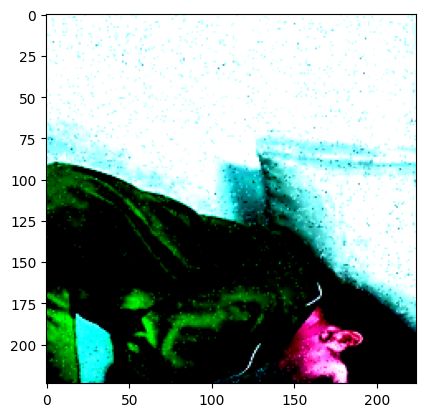

Label: 0


In [14]:
visualize_data(train_dataloader)

In [15]:
model = vit_model().to(device)
summary(model, input_size=(batch_size, IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

Layer (type:depth-idx)                                  Output Shape              Param #
vit_model                                               [64, 2]                   --
├─PatchEmbeddingLayer: 1-1                              [64, 197, 768]            200,448
│    └─Conv2d: 2-1                                      [64, 768, 14, 14]         590,592
│    └─Flatten: 2-2                                     [64, 196, 768]            --
├─Sequential: 1-2                                       [64, 197, 768]            --
│    └─TransformerBlock: 2-3                            [64, 197, 768]            --
│    │    └─MultiHeadSelfAttentionBlock: 3-1            [64, 197, 768]            2,363,904
│    │    └─MachineLearningPerceptronBlock: 3-2         [64, 197, 768]            4,723,968
│    └─TransformerBlock: 2-4                            [64, 197, 768]            --
│    │    └─MultiHeadSelfAttentionBlock: 3-3            [64, 197, 768]            2,363,904
│    │    └─MachineLearningPe

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loop(train_dataloader, model, loss_fn, optimizer)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6530 - acc: 0.6442



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6363 - acc: 0.6562



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5505 - acc: 0.7043



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5032 - acc: 0.7452



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5249 - acc: 0.7236



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4711 - acc: 0.7764



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4766 - acc: 0.7644



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4640 - acc: 0.7740



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.4389 - acc: 0.7788



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5239 - acc: 0.7308



In [16]:
def train_cifar(config, data_dir=None):
    model = vit_model()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0


    train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=1)

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_dataloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = loss_fn(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps, "accuracy": correct / total},
                checkpoint=checkpoint,
            )
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [17]:
def test_accuracy(model, device="cpu"):
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [18]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")
    config = {
        "lr": tune.loguniform(1e-4, 4e-4, 1e-5),
        "batch_size": tune.choice([16, 32, 64])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # ``parameter_columns=["l1", "l2", "lr", "batch_size"]``,
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = vit_model()
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

In [19]:
main(num_samples=10, max_num_epochs=20, gpus_per_trial=0)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-05 15:02:05,648	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-05 15:02:06,476	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-05-05 15:02:06,678	WARNING tune.py:900 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2024-05-05_15-02-06   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2024-05-05_15-02-06
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-05_15-02-03_525831_2651/artifacts/2024-05-05_15-02-06/train_cifar_2024-05-05_15-02-06/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-05-05 15:02:06. Total running time: 0s
Logical resource usage: 8.0/8 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------

(func pid=4639) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(func pid=4639)   self.pid = os.fork()



Trial status: 4 RUNNING | 6 PENDING
Current time: 2024-05-05 15:02:37. Total running time: 30s
Logical resource usage: 8.0/8 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------+
| Trial name                status              lr     batch_size |
+-----------------------------------------------------------------+
| train_cifar_7058e_00000   RUNNING    0.000324999             32 |
| train_cifar_7058e_00001   RUNNING    0.000314268             32 |
| train_cifar_7058e_00002   RUNNING    0.000313549             32 |
| train_cifar_7058e_00003   RUNNING    0.000322661             16 |
| train_cifar_7058e_00004   PENDING    0.000156068             64 |
| train_cifar_7058e_00005   PENDING    0.000227605             16 |
| train_cifar_7058e_00006   PENDING    0.000217526             16 |
| train_cifar_7058e_00007   PENDING    0.000369766             16 |
| train_cifar_7058e_00008   PENDING    0.000251753             32 |
| train_cifar

2024-05-05 15:11:15,211	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_7058e_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=4639, ip=172.28.0.12, actor_id=38a17d6b85


Trial train_cifar_7058e_00000 errored after 0 iterations at 2024-05-05 15:11:15. Total running time: 9min 8s
Error file: /tmp/ray/session_2024-05-05_15-02-03_525831_2651/artifacts/2024-05-05_15-02-06/train_cifar_2024-05-05_15-02-06/driver_artifacts/train_cifar_7058e_00000_0_batch_size=32,lr=0.0003_2024-05-05_15-02-06/error.txt

Trial train_cifar_7058e_00003 errored after 0 iterations at 2024-05-05 15:11:15. Total running time: 9min 8s
Error file: /tmp/ray/session_2024-05-05_15-02-03_525831_2651/artifacts/2024-05-05_15-02-06/train_cifar_2024-05-05_15-02-06/driver_artifacts/train_cifar_7058e_00003_3_batch_size=16,lr=0.0003_2024-05-05_15-02-06/error.txt

Trial train_cifar_7058e_00002 errored after 0 iterations at 2024-05-05 15:11:15. Total running time: 9min 8s
Error file: /tmp/ray/session_2024-05-05_15-02-03_525831_2651/artifacts/2024-05-05_15-02-06/train_cifar_2024-05-05_15-02-06/driver_artifacts/train_cifar_7058e_00002_2_batch_size=32,lr=0.0003_2024-05-05_15-02-06/error.txt


2024-05-05 15:11:15,497	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_7058e_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=4640, ip=172.28.0.12, actor_id=e9768cd462


Trial train_cifar_7058e_00001 errored after 0 iterations at 2024-05-05 15:11:15. Total running time: 9min 8s
Error file: /tmp/ray/session_2024-05-05_15-02-03_525831_2651/artifacts/2024-05-05_15-02-06/train_cifar_2024-05-05_15-02-06/driver_artifacts/train_cifar_7058e_00001_1_batch_size=32,lr=0.0003_2024-05-05_15-02-06/error.txt

Trial train_cifar_7058e_00005 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_7058e_00005 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| lr                                       0.00023 |
+--------------------------------------------------+

Trial train_cifar_7058e_00006 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_7058e_00006 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| lr                  

(func pid=7452) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock. [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(func pid=7452)   self.pid = os.fork() [repeated 4x across cluster]



Trial status: 4 ERROR | 4 RUNNING | 2 PENDING
Current time: 2024-05-05 15:11:38. Total running time: 9min 31s
Logical resource usage: 8.0/8 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------+
| Trial name                status              lr     batch_size |
+-----------------------------------------------------------------+
| train_cifar_7058e_00004   RUNNING    0.000156068             64 |
| train_cifar_7058e_00005   RUNNING    0.000227605             16 |
| train_cifar_7058e_00006   RUNNING    0.000217526             16 |
| train_cifar_7058e_00007   RUNNING    0.000369766             16 |
| train_cifar_7058e_00008   PENDING    0.000251753             32 |
| train_cifar_7058e_00009   PENDING    0.000315797             64 |
| train_cifar_7058e_00000   ERROR      0.000324999             32 |
| train_cifar_7058e_00001   ERROR      0.000314268             32 |
| train_cifar_7058e_00002   ERROR      0.000313549             32 

RuntimeError: Caught unexpected exception: Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 9fb2e562ad3454a23d95fde9d7814267db08c2143162764f23dbaf91) where the task (actor ID: 976eb4adc33633da7b9a81ad01000000, name=ImplicitFunc.__init__, pid=7448, memory used=10.16GB) was running was 48.58GB / 50.99GB (0.952679), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 512e29e1f47d555cc08a69d16ff993ea8d36961534776a39ea7f02ef) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-512e29e1f47d555cc08a69d16ff993ea8d36961534776a39ea7f02ef*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
7451	10.91	ray::ImplicitFunc.train
7455	10.73	ray::ImplicitFunc.train
7452	10.72	ray::ImplicitFunc.train
7448	10.16	ray::ImplicitFunc.train
2651	0.68	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-85007d5f-49a8...
3535	0.53	node /datalab/web/pyright/pyright-langserver.js --stdio --cancellationReceive=file:9316c4f8920554b1a...
7662	0.45	ray::ImplicitFunc.train
7653	0.44	ray::ImplicitFunc.train
7644	0.42	ray::ImplicitFunc.train
7635	0.42	ray::ImplicitFunc.train
Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. Set max_restarts and max_task_retries to enable retry when the task crashes due to OOM. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

In [ ]:
# Performance on Valid/Test Data
def overall_accuracy(model, test_dataloader, loss_fn):

    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_dataloader):
        X, y = data[0].to('cpu'), data[1].to('cpu')
        output = model(X)
        test_loss += loss_fn(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1

    accuracy = correct/total

    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])

    return test_loss, accuracy, y_proba_out, y_truth_out


loss, acc, y_proba, y_truth = overall_accuracy(model, test_dataloader, criterion = nn.CrossEntropyLoss())


print(f"Accuracy: {acc}")

print(pd.value_counts(y_truth))